# Splicing autopsy - assessing the damage #

January 26, 2017  
Author: Kimberly Insigne

We realized today that there is a fatal error in the exon skipping library design. The GFP was split in such a way that the intron-exon-intron library construct is shifted by 1bp, causing a frameshift mutation. As a reminder, in this assay we quantify exon skipping by measuring re-constituted GFP fluorescence and exon inclusion as lack of fluorescence. If the exon is skipped, the frameshift should not have any effect (assuming splicing is independent of translation). If the exon is included, it will still not have any effect. If the frameshift mutation introduces a premature stop codon it does not matter for our readout because for exon inclusion the GFP will never glow in the first place. However, the frameshift is a problem because:

- In `splicemod`, only synonymous mutations were made. In this new reading frame, the mutations are no longer guaranteed to be synonymous and the amino acid sequence of the mutant can be different from the natural. This technically shouldn't matter if you believe splicing takes place independent of translation. 
- For the ExAC variants, there were missense mutations as well in the database but now all the annotations from ExAC are different in our assay for this different reading frame. Once again, this technically shouldn't matter if splicing is independent of translation

Let's take a look at a) how many times a premature stop codon is introduced and b) how the protein sequence of the mutants compares to the natural

In [1]:
# setup
import sys
sys.path.append('/Users/Kimberly/Documents/scripts')
from itertools import ifilter, chain
from copy import copy
from Bio.Seq import Seq
from collections import Counter
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the fasta files
from helpful_utils import fasta_reader

mut_seqs = fasta_reader('mut_ref.fa')
print "Number of mutant sequences:", len(mut_seqs)

nat_seqs = fasta_reader('nat_ref.fa')
print "Number of natural sequences:", len(nat_seqs)

Number of mutant sequences: 17291
Number of natural sequences: 9722


In [3]:
def parse_lengths(header):
    """
    Strand information and intron-exon-intron lengths stored in 'strand' and 'len' fields, respectively. If strand
    is negative, reverse intron 1 and intron 2 coordinates
    """
    
    fields = header.split()
    strand = list(ifilter(lambda x: 'strand' in x, fields))
    # e.g. 'strand=-1'
    strand = strand[0].split('=')[1]
    if strand != '':
        strand = int(strand)
    # intron-exon-intron length stored in len field, e.g. "len=42.75.53".
    lengths = list(ifilter(lambda x: 'len' in x, fields))[0].split('=')[1]
    
    intron1_len = ''
    exon_len = ''
    intron2_len = ''
    
    if lengths != '':
        if strand == 1:
            intron1_len, exon_len, intron2_len = map(int, lengths.split('.'))
        elif strand == -1:
            intron2_len, exon_len, intron1_len = map(int, lengths.split('.'))
    
    return (intron1_len, exon_len, intron2_len)

In [4]:
mut_lens = [parse_lengths(header) for header in mut_seqs]
nat_lens = [parse_lengths(header) for header in nat_seqs]

In [5]:
def extract_exon_seq(seqs, lens):
    """
    seqs: dictionary, keys are headers and values are sequences
    lens: list of tuples, (intron1_len, exon_len, intron2_len)
    returns: exon sequences based on coordinates
    """
    exon_seqs = {}
    for i in range(len(lens)):
        header = seqs.keys()[i]
        id = header.split()[0]
        seq = seqs[header]
        if '' not in lens[i]:
            intron1_len, exon_len, intron2_len = lens[i]
            exon_seq = seq[intron1_len : (intron1_len + exon_len)]
            exon_seqs[id] = exon_seq
    return exon_seqs

mut_exon_seqs = extract_exon_seq(mut_seqs, mut_lens)
nat_exon_seqs = extract_exon_seq(nat_seqs, nat_lens)

In [6]:
# append '_000' to natural sequences, combine
nat_exon_seqs = {x+'_000' : nat_exon_seqs[x] for x in nat_exon_seqs}
exon_seqs = copy(mut_exon_seqs)
exon_seqs.update(nat_exon_seqs)

In [7]:
# GFP split mistake adds 'A' to front of sequence and 'CG' to end. To simulate frameshift, delete first two bases and
# last base

exon_seqs_shift = {x : exon_seqs[x][1:-2] for x in exon_seqs}

In [8]:
# exons will be translated through any stop codons, which are denoted by '*'
exon_prot = {x : Seq(exon_seqs_shift[x]).translate() for x in exon_seqs_shift}

Counter({0: 8700, 1: 8418, 2: 5235, 3: 2824, 4: 895, 5: 332, 6: 190, 7: 67, 8: 2, 9: 2, 11: 1})


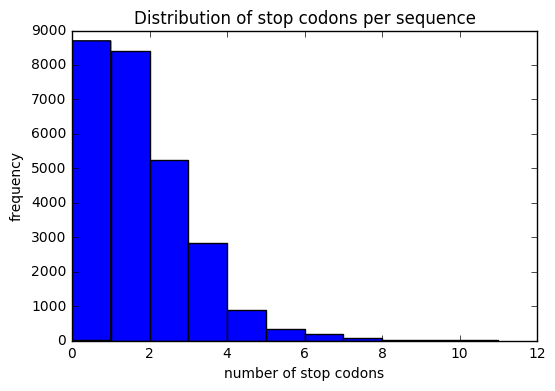

In [14]:
# stop codons per sequence
num_stop_codons = [str(x).count('*') for x in exon_prot.values()]
print Counter(num_stop_codons)
binwidth = 1
plt.hist(num_stop_codons, bins=np.arange(min(num_stop_codons), max(num_stop_codons) + binwidth, binwidth))
plt.title('Distribution of stop codons per sequence')
plt.xlabel('number of stop codons')
plt.ylabel('frequency')
plt.show()

The frameshift did not introduce stop codons for 32% of the library, but for 31.5% one stop codon was introduced.

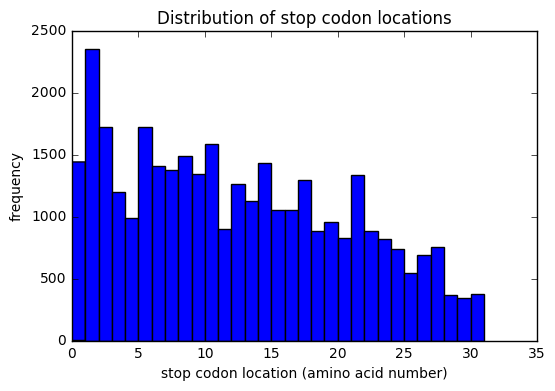

In [10]:
stop_codon_locs = [[m.start() for m in re.finditer('\*', str(seq))] for seq in exon_prot.values()]
stop_codon_locs = list(chain(*stop_codon_locs))
plt.hist(stop_codon_locs, bins=np.arange(min(stop_codon_locs), max(stop_codon_locs) + binwidth, binwidth))
plt.title('Distribution of stop codon locations')
plt.xlabel('stop codon location (amino acid number)')
plt.ylabel('frequency')
plt.show()

The location of introduced stop codons is somewhat evenly distributed.

In [11]:
# number of non-synonymous changes between mutants and natural sequence
nat_exon_seqs = {x: exon_prot[x] for x in exon_prot if '_000' in x}
mut_exon_seqs = {x: exon_prot[x] for x in exon_prot if '_000' not in x}

# for x in nat_exon_seqs:
#     basename = x.replace('_000', '')
#     nat = str(nat_exon_seqs[x]
#     muts = [str(mut_exon_seqs[y]) for y in mut_exon_seqs if basename in y]
    

In [12]:
num_diff = []

for x in nat_exon_seqs:
    basename = x.replace('_000', '')
    nat = nat_exon_seqs[x]
    muts = [mut_exon_seqs[y] for y in mut_exon_seqs if basename in y]
    num_diff.extend([sum(1 for a, b in zip(str(nat), str(mut)) if a != b) for mut in muts])

Counter({0: 10720, 1: 1440, 2: 1345, 3: 901, 4: 480, 5: 402, 6: 193, 7: 190, 8: 148, 9: 99, 10: 81, 11: 78, 28: 69, 25: 65, 26: 64, 29: 64, 12: 62, 22: 59, 23: 59, 27: 56, 13: 53, 21: 52, 16: 48, 24: 47, 14: 44, 19: 38, 15: 36, 30: 35, 17: 34, 20: 34, 18: 24, 31: 11, 32: 1})


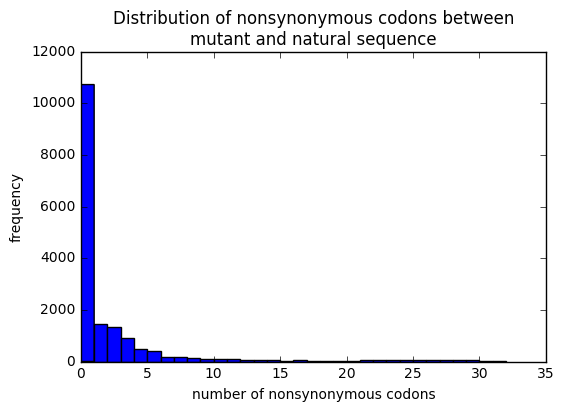

In [13]:
print Counter(num_diff)
plt.hist(num_diff, bins=np.arange(min(num_diff), max(num_diff) + binwidth, binwidth))
plt.title('Distribution of nonsynonymous codons between\nmutant and natural sequence')
plt.xlabel('number of nonsynonymous codons')
plt.ylabel('frequency')
plt.show()

62.9% (10720/17032) of mutations resulted in synonymous codon changes while the remaining 37.1% of mutations results in non-synonmous changes, with one mutant sequence resulting in 32 amino acid changes.